# Trabajo practico: Prediccion de lluvia Australia

Alumnos: Noir Nicolas, González Ignacio

Año: 2024

Materia: Aprendizaje automático 1

Carrera: TUIA

## Librerias

In [1]:
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install plotly
# !pip install optuna
# !pip install shap
# !pip install pycaret[full]
# !pip install optuna-integration[sklearn]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
import plotly.express as px
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn import metrics
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, roc_curve, roc_auc_score, auc , jaccard_score, matthews_corrcoef, mean_squared_error, make_scorer
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from category_encoders import OneHotEncoder
import optuna
import shap
import pycaret
from pycaret.classification import *
from pandas.core.frame import DataFrame
from pandas.core.frame import Series
# Libreria necesaria para poder ocultar errores que empeoran la visualización del notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None


## Introducción
En este trabajo vamos a crear un modelo de clasificación para la predicción de la lluvia al día siguiente en Australia en 10 ciudades elegidas al azar.

Para esto necesitaremos hacer ciertos análisis, escalados, imputados, etc., los cuales vamos a presentar brevemente a continuación (en el código va a ser explicado y justificado):

Primero necesitamos importar el dataset. Como este tiene más de 10 ciudades de Australia, haremos una selección al azar con sample y reduciremos el dataset a los datos que sean de esas ciudades. El siguiente paso es dropear todos los registros que tengan un valor faltante en la variable explicativa, después chequearemos y eliminaremos filas duplicadas. Una vez hecho esta pequeña limpieza inicial, dividimos el dataset en train y test, siendo 80/20 la proporción. También tendremos que dividirlo de manera que en el punto donde se divida para atrás en fecha sea entrenamiento y para adelante sea prueba. A continuación analizaremos los valores faltantes de x_train, decidiendo qué filas son dropeadas por la cantidad de valores faltantes. Lo siguiente es el análisis de las distribuciones, correlaciones, tipos de datos, outliers, medias, medianas, etc.
Después codificamos las variables categóricas y cíclicas para poder imputar valores faltantes mediante MICE con LinearRegression o Interpolación. Una vez imputados los valores faltantes, corregimos los valores erróneos, que pueden ser valores negativos o fuera de la escala/rango o fuera de su tipo de dato. Por ejemplo, en el caso de Rainfall no puede haber lluvia negativa. El siguiente paso es decodificar las variables Location y las direcciones del viento, ya que fueron codificadas con ordinal encoder para su posible uso en la imputación. Ahora es necesario devolverlos a su forma original y codificarlos de nuevo para que sean utilizables en la regresión logística. Pasamos a la creación de los modelos de clasificación, donde haremos 4 modelos de clasificación. Uno por cada tipo de método de imputación y a su vez uno por cada valor del parámetro de class_weight de LogisticRegression que puede ser balanced donde imita un balanceo del dataset o default en el que se usa la regresión logística con los datos que tenemos, aunque estén desbalanceados. Calculamos todas las métricas de clasificación y la que vamos a elegir para comparar los modelos va a ser el recall.

## Código

### Funciones

In [ ]:
def funciones_roc(y_true : Series, y_prob1 : Series, nombre_1 : str, y_prob2 : Series=None, nombre_2 : str=None) -> None:
    """
    Grafica la curva ROC de uno o dos modelos.

    Parameters
    ----------
    y_true: Series
        Variable target del dataset.
    y_prob1: Series
        Probabilidades de predecir la clase verdadera de cada dato del primer modelo.
    nombre_1: str
        Nombre del primer modelo
    y_prob2: Series
        Probabilidades de predecir la clase verdadera de cada dato del segundo modelo
    nombre_2: str
        Nombre del segundo modelo
    
    """
    
    if y_prob2 is None:
        fpr_relog, tpr_relog, thresholds_relog = roc_curve(y_true, y_prob1)
        roc_auc_relog = auc(fpr_relog, tpr_relog)

        optimal_idx_relog = np.argmax(tpr_relog - fpr_relog)
        best_thresh_relog = thresholds_relog[optimal_idx_relog]
        best_fpr_relog = fpr_relog[optimal_idx_relog]
        best_tpr_relog = tpr_relog[optimal_idx_relog]

        plt.plot(fpr_relog, tpr_relog, color='darkorange', lw=2, label=f'{nombre_1} (AUC = %0.4f)' % roc_auc_relog)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.scatter(best_fpr_relog, best_tpr_relog, color='red', label=f'índice de Younden (Threshold = {best_thresh_relog:.4f})')
        plt.text(best_fpr_relog, best_tpr_relog, f'({best_fpr_relog:.2f}, {best_tpr_relog:.2f})', color='red', ha='right')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos (FPR)')
        plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
        plt.title(f'Curva ROC - {nombre_1}')
        plt.legend(loc="lower right")
    else:
        fpr_relog, tpr_relog, thresholds_relog = roc_curve(y_true, y_prob1)
        roc_auc_relog = auc(fpr_relog, tpr_relog)

        # Curva ROC para el modelo desbalanceado
        fpr_relog_desba, tpr_relog_desba, thresholds_relog_desba = roc_curve(y_true, y_prob2)
        roc_auc_relog_desba = auc(fpr_relog_desba, tpr_relog_desba)

        optimal_idx_relog = np.argmax(tpr_relog - fpr_relog)
        best_thresh_relog = thresholds_relog[optimal_idx_relog]
        best_fpr_relog = fpr_relog[optimal_idx_relog]
        best_tpr_relog = tpr_relog[optimal_idx_relog]

        optimal_idx_relog_desba = np.argmax(tpr_relog_desba - fpr_relog_desba)
        best_thresh_desba = thresholds_relog_desba[optimal_idx_relog_desba]
        best_fpr_relog_desba = fpr_relog_desba[optimal_idx_relog_desba]
        best_tpr_relog_desba = tpr_relog_desba[optimal_idx_relog_desba]

        # Crear la figura con 2 subplots (1 fila, 2 columnas)
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Gráfico para el modelo balanceado
        axes[0].plot(fpr_relog, tpr_relog, color='darkorange', lw=2, label=f'{nombre_1} (AUC = %0.4f)' % roc_auc_relog)
        axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0].scatter(best_fpr_relog, best_tpr_relog, color='red', label=f'índice de Younden (Threshold = {best_thresh_relog:.4f})')
        axes[0].text(best_fpr_relog, best_tpr_relog, f'({best_fpr_relog:.2f}, {best_tpr_relog:.2f})', color='red', ha='right')
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('Tasa de Falsos Positivos (FPR)')
        axes[0].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
        axes[0].set_title(f'Curva ROC - {nombre_1}')
        axes[0].legend(loc="lower right")

        # Gráfico para el modelo desbalanceado
        axes[1].plot(fpr_relog_desba, tpr_relog_desba, color='green', lw=2, label=f'{nombre_2} (AUC = %0.4f)' % roc_auc_relog_desba)
        axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[1].scatter(best_fpr_relog_desba, best_tpr_relog_desba, color='red', label=f'índice de Younden (Threshold = {best_thresh_desba:.4f})')
        axes[1].text(best_fpr_relog_desba, best_tpr_relog_desba, f'({best_fpr_relog_desba:.2f}, {best_tpr_relog_desba:.2f})', color='red', ha='right')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
        axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
        axes[1].set_title(f'Curva ROC - {nombre_2}')
        axes[1].legend(loc="lower right")

        plt.tight_layout()
        plt.show()

In [ ]:
def metrica_recalls(recall_clase0, recall_clase1):
    metrica = 2 * ((recall_clase0*recall_clase1) / (recall_clase0+recall_clase1))
    return metrica

In [ ]:
def calcular_wrecall_estimador(y_true, y_pred, **kwargs):
    recall_llueve = recall_score(y_true, y_pred, pos_label=1)
    recall_no_llueve = recall_score(y_true, y_pred, pos_label=0)
    wrecall = metrica_recalls(recall_no_llueve, recall_llueve)
    return wrecall

In [163]:
def calcular_metricas_modelo(y_true, y_pred, nombre_modelo):
    metricas_llueve = {
    'Accuracy': accuracy_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred, pos_label=1),
    'Recall': recall_score(y_true, y_pred, pos_label=1),
    'F1': f1_score(y_true, y_pred, pos_label=1),
    'Matthews': matthews_corrcoef(y_true, y_pred),
    'Jaccard': jaccard_score(y_true, y_pred),
    'Wrecall': calcular_wrecall_estimador(y_true, y_pred)

    }

    metricas_no_llueve = {
    'Accuracy': accuracy_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred, pos_label=0),
    'Recall': recall_score(y_true, y_pred, pos_label=0),
    'F1': f1_score(y_true, y_pred, pos_label=0),
    'Matthews': matthews_corrcoef(y_true, y_pred),
    'Jaccard': jaccard_score(y_true, y_pred),
    'Wrecall': calcular_wrecall_estimador(y_true, y_pred)
    }
    metricas_comparadas = pd.DataFrame([metricas_llueve,metricas_no_llueve], index=[f'{nombre_modelo} - Llueve',f'{nombre_modelo} - No Llueve'])

    return metricas_comparadas

In [ ]:
def positivisar(df):

    variables = [ 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm']

    columnas = df.columns
    for col in columnas:
        if col in ['MinTemp','MaxTemp','Temp9am','Temp3pm', 'RainToday_Yes']:
            continue
        df[col][df[col] < 0] = 0
        df[col] = df[col].round(1)
        if col in variables:
            df[col] = df[col].astype(int)
        if col in ['Cloud9am', 'Cloud3pm']:
            df[col] = df[col].replace([9, 10], 8) 
    return df

In [ ]:
def merge_var(df, df2):
    x_index = df.reset_index().drop('Date', axis=1)
    x_vacio = x_index.drop(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1)
    x_decodif = pd.DataFrame(data=df2, columns= ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])
    x_train_merge_imp = pd.merge(x_vacio, x_decodif,left_index=True, right_index=True, how='left')
    return x_train_merge_imp

In [ ]:
def codificar_variables(dataset):
    """
    Codifica y reemplaza date, WindGustDir, WindDir9am, WindDir3pm, Raintoday, Location
    """
    
    dataset['sin_week'] = np.sin(2 * np.pi * dataset['week_year'] / 52)
    dataset['cos_week'] = np.cos(2 * np.pi * dataset['week_year'] / 52)
    dataset.drop('week_year', axis=1, inplace=True)

    puntos_cardinales = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W','NW']

    angulos = np.arange(0, 360, 45)
    df_angulos_cardinal = pd.DataFrame({'puntos': puntos_cardinales, 'angulos': angulos})
    
    dataset_ang = dataset.merge(df_angulos_cardinal, left_on='WindGustDir', right_on=['puntos'], how='left')
    dataset_ang = dataset.merge(df_angulos_cardinal, left_on='WindDir9am', right_on=['puntos'], how='left')
    dataset_ang = dataset.merge(df_angulos_cardinal, left_on='WindDir3pm', right_on=['puntos'], how='left')

    dataset_ang['sin_WindGustDir'] = round(np.sin(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)
    dataset_ang['cos_WindGustDir'] = round(np.cos(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)

    dataset_ang['sin_WindDir9am'] = round(np.sin(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)
    dataset_ang['cos_WindDir9am'] = round(np.cos(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)

    dataset_ang['sin_WindDir3pm'] = round(np.sin(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)
    dataset_ang['cos_WindDir3pm'] = round(np.cos(2 * np.pi * dataset_ang['angulos'] / 360), ndigits=4)

        
    dataset_ang.drop('WindGustDir', axis=1, inplace=True)
    dataset_ang.drop('WindDir9am', axis=1, inplace=True)
    dataset_ang.drop('WindDir3pm', axis=1, inplace=True)

    dataset_ang.drop('angulos', axis=1, inplace=True)
    dataset_ang.drop('puntos', axis=1, inplace=True)
    
    dataset_codificado = pd.get_dummies(dataset_ang, columns=['Location'], drop_first=True)
    dataset_codificado['RainToday_Yes'] = dataset_codificado['RainToday_Yes'].astype(int)
    return dataset_codificado

### Análisis descriptivo

In [4]:
dataset_lluvia_completo_raw = pd.read_csv('https://raw.githubusercontent.com/nacho-gonz/AA1-Archivos-2024/master/weatherAUS.csv')
ciudades_elegidas = dataset_lluvia_completo_raw["Location"].sample(10, random_state=528548).to_list()
df_ciudad = dataset_lluvia_completo_raw[dataset_lluvia_completo_raw["Location"].isin(ciudades_elegidas)]
df_ciudad.dropna(subset=['RainTomorrow'], inplace=True)

df_ciudad_ord = df_ciudad.sort_values(by='Date')

Importamos el dataset y elegimos 10 ciudades la azar, dropeamos todas las filas que tengan valores faltantes en la variable target y ordenamos el dataset. Esto para que no haya fuga de datos entre train y test, ya que al ser una serie de tiempo necesito que todos los días del conjunto de test no esten mezclados en train.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df_ciudad_ord.drop("RainTomorrow", axis=1), df_ciudad_ord['RainTomorrow'].values.reshape(-1,1), shuffle=False, test_size=0.2, random_state=28869)

In [6]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((23095, 22), (5774, 22), (23095, 1), (5774, 1))

In [7]:
valores_faltantes = x_train[x_train.isna().any(axis=1)]
valores_faltantes.shape

(11697, 22)

Vemos que hay muchas filas con valores faltantes, el 50% de los datos, esto descarta la posibilidad de dropear todas las filas con valores faltantes, ya que supera el 5% de los datos. Además en una serie de tiempo es necesario tener un análisis más profundo de estos datos faltantes, ya que podría estar sesgando mi modelo por no poder descubrir patrones al quitar estos valores faltantes.

In [8]:
valores_faltantes.isna().sum(axis=0)

Date                0
Location            0
MinTemp           252
MaxTemp           148
Rainfall          238
Evaporation      9876
Sunshine         8173
WindGustDir      2995
WindGustSpeed    2978
WindDir9am       2185
WindDir3pm       1070
WindSpeed9am      465
WindSpeed3pm      632
Humidity9am       255
Humidity3pm       385
Pressure9am      5028
Pressure3pm      5033
Cloud9am         5292
Cloud3pm         5882
Temp9am           173
Temp3pm           343
RainToday         238
dtype: int64

Vemos cuales son las columnas con mayor cantidad de datos faltantes (Evaporation, Sunshine, Cloud3pm, Cloud9am), menor cantidad valores faltantes (RainFall, RainToday, Temp) y ausencia de valores faltantes (Date, Location). 

In [9]:
valores_faltantes.isna().sum(axis=1).value_counts(sort=True)

6     3321
1     2451
4     1614
2     1277
3     1077
7      813
11     315
8      293
5      183
12     177
9       39
17      37
18      28
13      28
10      15
19      10
14      10
15       4
20       4
16       1
dtype: int64

Observamos la cantidad de filas que tienen diferentes cantidad de valores faltantes. 

In [10]:
x_train_compl = x_train.copy()
x_train_compl['RainTomorrow'] = y_train.flatten()
x_train_compl.dropna(thresh=8, inplace=True)

y_train_modif = x_train_compl['RainTomorrow']
x_train_modif = x_train_compl.drop(columns='RainTomorrow')
y_train_codif = pd.get_dummies(y_train_modif, drop_first=True)
y_test_codif = pd.get_dummies(y_test.flatten(), drop_first=True)

In [11]:
x_train_modif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23015 entries, 45587 to 17530
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           23015 non-null  object 
 1   Location       23015 non-null  object 
 2   MinTemp        22842 non-null  float64
 3   MaxTemp        22904 non-null  float64
 4   Rainfall       22792 non-null  float64
 5   Evaporation    13219 non-null  float64
 6   Sunshine       14917 non-null  float64
 7   WindGustDir    20099 non-null  object 
 8   WindGustSpeed  20116 non-null  float64
 9   WindDir9am     20910 non-null  object 
 10  WindDir3pm     22025 non-null  object 
 11  WindSpeed9am   22630 non-null  float64
 12  WindSpeed3pm   22463 non-null  float64
 13  Humidity9am    22840 non-null  float64
 14  Humidity3pm    22710 non-null  float64
 15  Pressure9am    18067 non-null  float64
 16  Pressure3pm    18062 non-null  float64
 17  Cloud9am       17803 non-null  float64
 18  Cl

In [12]:
print(x_train_modif.groupby('Location').describe().transpose().to_string())

Location                Brisbane     Canberra        Moree    Newcastle         Nhil    Nuriootpa   PearceRAAF        Perth         Sale   SalmonGums
MinTemp       count  2580.000000  2829.000000  2290.000000  2186.000000   985.000000  2409.000000  2165.000000  2608.000000  2420.000000  2370.000000
              mean     16.108333     6.591622    12.407467    13.422049     8.497868     9.246866    12.387252    12.834164     8.332479     9.276287
              std       4.635506     6.233339     6.786552     5.000512     4.958333     5.048927     5.301746     5.131978     4.900524     5.483400
              min       2.600000    -8.000000    -3.300000     2.200000    -2.300000    -3.500000    -1.900000    -0.600000    -3.900000    -4.400000
              25%      12.500000     1.600000     6.600000     9.400000     5.000000     5.800000     8.700000     9.100000     4.700000     5.300000
              50%      16.400000     6.700000    13.000000    13.500000     8.000000     8.900000   

Observamos todas las medidas descriptivas de cada variable por localidad. 

En MinTemp podemos ver que hay diferencias significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 28, notamos que las medianas varían entre 6 y 16. Esto lo puedo comparar con la mediana general que es 11.

En MaxTemp se ven diferencias significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 16.6, notamos que las medianas varían entre 19.1 y 26.8. Esto lo puedo comparar con la mediana general que es 23.

En RainFall no se ven diferencias entre las localidades, siendo que el RIQ entre todas las ciudades es de 1.2, notamos que las medianas varían entre 0 y 0.

En Evaporation se ven diferencias significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 7.4, notamos que las medianas varían entre 3.4 y 6.2. Además se observa que 4 de estas ciudades no tienen valores medidos para esta variable. Esto lo puedo comparar con la mediana general que es 4.4.

En Sunshise se ven diferencia significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 7.5, notamos que las medianas varían entre 7 y 10. Esto lo podemos comparar con la mediana general que es 9.

En WindGustSpeed se ven diferencia significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 30, notamos que las medianas varían entre 28 y 43. Esto lo podemos comparar con la mediana general que es 37.

En Windspeed9am se ven diferencia significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 24, notamos que las medianas varían entre 4 y 17. Esto lo podemos comparar con la mediana general que es 11.

En Windspeed3pm se ven diferencia significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 26, notamos que las medianas varían entre 7 y 22. Esto lo podemos comparar con la mediana general que es 15.

En Humidity9am se ven diferencia significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 45, notamos que las medianas varían entre 59 y 80. Esto lo podemos comparar con la mediana general que es 68.

En Humidity3pm se ven diferencia significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 45, notamos que las medianas varían entre 32 y 58. Esto lo podemos comparar con la mediana general que es 46.

En Pressure9am no se ven diferencia significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 12, notamos que las medianas varían entre 1017.5 y 1019.2.

En Pressure3pm no se ven diferencia significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 11, notamos que las medianas varían entre 1014.9 y 1017.

En Cloud9am se ven diferencia significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 6, notamos que las medianas varían entre 2 y 6. Esto lo podemos comparar con la mediana general que es 4.

En Cloud9am se ven diferencia significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 6, notamos que las medianas varían entre 3 y 6. Esto lo podemos comparar con la mediana general que es 5.

En Temp9am podemos ver que hay diferencias significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 17, notamos que las medianas varían entre 12.3 y 22.1. Esto lo puedo comparar con la mediana general que es 16.5.

En Temp3pm se ven diferencias significativas entre las localidades, siendo que el RIQ entre todas las ciudades es de 17, notamos que las medianas varían entre 17.6 y 25.5. Esto lo puedo comparar con la mediana general que es 21.7.

In [13]:
# graficar_valores = x_train_compl[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
#       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
#       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
#       'Temp3pm','RainTomorrow']]

# fig, axes = plt.subplots(8,2)

# for name, ax in zip(graficar_valores, axes.flatten()):
#    sns.boxplot(x=name, data=graficar_valores, orient='h', ax=ax, hue='RainTomorrow')

# fig.set_size_inches(18,28)
# plt.tight_layout()
# plt.show()

In [14]:
# fig2, axes2 = plt.subplots(8,2)

# for name, ax in zip(graficar_valores, axes2.flatten()):
#    if name == "Rainfall":
#        sns.histplot(x=name, data=graficar_valores, ax=ax,kde=True, bins=70, hue='RainTomorrow')
#    else:
#        sns.histplot(x=name, data=graficar_valores, ax=ax,kde=True, hue='RainTomorrow')

# fig2.set_size_inches(18,28)
# plt.tight_layout()
# plt.show()

In [15]:
# sns.pairplot(graficar_valores, hue='RainTomorrow', corner=True)
# plt.show()

In [16]:
# vientos = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainTomorrow']

# fig, axes = plt.subplots(2,2)

# for name, ax in zip(vientos, axes.flatten()):
#    sns.countplot(y=name, data=x_train_compl[vientos], orient='h', ax=ax, hue='RainTomorrow')
#    if name  == 'WindGustDir':
#        ax.title.set_text('Frecuancia de las direcicones de las rafagas de vientos')
#    if name == 'WindDir9am':
#        ax.title.set_text('Frecuancia de las direcicones del viento a las 9am')
#    if name == 'WindDir3pm':
#        ax.title.set_text('Frecuancia de las direcicones del viento a las 3am')
#    else:
#        ax.title.set_text('Frecuencia de las precipitaciones al dia siguiente')

# fig.set_size_inches(18,14)
# plt.tight_layout()
# plt.show()

In [17]:
# localidades = x_train_modif[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
#     'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
#     'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
#     'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
#     'Temp3pm', 'RainToday']]

# fig, axes = plt.subplots(8,2)

# for name, ax in zip(localidades, axes.flatten()):
#     sns.boxplot(y=name, data=localidades, orient='v', ax=ax, hue='Location')

# fig.set_size_inches(18,30)
# plt.tight_layout()
# plt.show()
    

In [18]:
# fig2, axes2 = plt.subplots(8,2)

# for name, ax in zip(localidades, axes2.flatten()):
#      if name == "Rainfall":
#          sns.histplot(x=name, data=localidades, ax=ax,kde=True, bins=70, hue='Location')
#      else:
#          sns.histplot(x=name, data=localidades, ax=ax,kde=True, hue='Location')

# fig2.set_size_inches(18,28)
# plt.tight_layout()
# plt.show()

<Axes: xlabel='count', ylabel='RainTomorrow'>

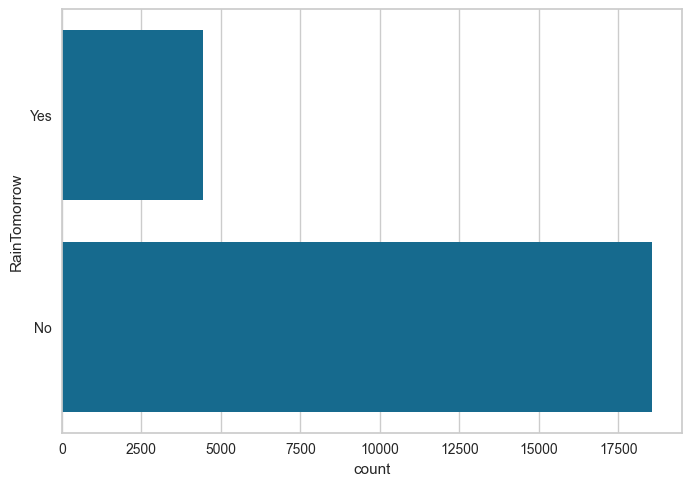

In [19]:
sns.countplot(data=x_train_compl, y='RainTomorrow')

In [20]:
x_train_compl['RainTomorrow'].value_counts()

No     18575
Yes     4440
Name: RainTomorrow, dtype: int64

El dataset no esta balanceado. 

Porque en algun momento se nos va a pedir que se tome una decision en base al balanceo del dataset, siendo undersampling u oversampling en sus diferentes formas o methodos.

---
-------
-------

In [21]:
puntos_8 = {'NNE': 'NE', 'ENE': 'E', 'ESE': 'SE', 'SSE':'S', 'SSW': 'SW', 'WSW': 'W', 'WNW': 'NW', 'NNW': 'N'}

x_train_modif['WindGustDir'] = x_train_modif['WindGustDir'].replace(puntos_8)
x_train_modif['WindDir9am'] = x_train_modif['WindDir9am'].replace(puntos_8)
x_train_modif['WindDir3pm'] = x_train_modif['WindDir3pm'].replace(puntos_8)

x_test['WindGustDir'] = x_test['WindGustDir'].replace(puntos_8)
x_test['WindDir9am'] = x_test['WindDir9am'].replace(puntos_8)
x_test['WindDir3pm'] = x_test['WindDir3pm'].replace(puntos_8)

Reemplazamos los puntos cardinales de las columnas WindGustDir, WindDir9am y WindDir3pm, que son 16, por los 8 puntos cardinales principales, rotando todos los ejes en sentido horario, pasando NNE a NE, de ENE a E, y así sucesivamente, para ambos conjuntos de datos (train y test

In [22]:
x_train_modif['Date'] = pd.to_datetime(x_train_modif['Date'])
x_train_modif['week_year'] = x_train_modif['Date'].dt.strftime('%U')

x_test['Date'] = pd.to_datetime(x_test['Date'])
x_test['week_year'] = x_test['Date'].dt.strftime('%U')

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).set_output(transform='pandas')

enc.fit(x_train_modif[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])


x_train_modif[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']] = enc.transform(x_train_modif[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])

x_test[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']] = enc.transform(x_test[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])

x_train_modif['week_year'] = x_train_modif['week_year'].astype(int)

x_test['week_year'] = x_test['week_year'].astype(int)

x_train_modif.index = x_train_modif['Date']
x_test.index = x_test['Date']


x_train_modif.drop('Date', axis=1, inplace=True)
x_test.drop('Date', axis=1, inplace=True)

In [23]:
x_train_modif.describe()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,week_year
count,23015.000000,22842.000000,22904.000000,22792.000000,13219.000000,14917.000000,20099.000000,20116.000000,20910.000000,22025.000000,...,22463.000000,22840.000000,22710.000000,18067.000000,18062.000000,17803.000000,17213.000000,22922.000000,22752.000000,23015.000000
mean,4.452748,10.990557,23.636863,1.882976,5.267781,8.091084,3.655505,38.619507,3.272740,3.856300,...,16.900681,67.428940,46.864289,1018.435595,1015.854280,4.094928,4.228548,16.713328,22.136054,26.163937
std,2.994102,6.136731,6.737359,6.933453,3.843972,3.661770,2.475019,12.913994,2.319763,2.363857,...,8.965012,18.300182,19.393619,6.848708,6.640418,2.892754,2.673243,6.105045,6.580321,14.750706
min,0.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,...,0.000000,3.000000,1.000000,987.400000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,2.000000,6.600000,18.600000,0.000000,2.600000,5.700000,1.000000,30.000000,1.000000,2.000000,...,11.000000,55.000000,32.000000,1013.800000,1011.300000,1.000000,2.000000,12.300000,17.200000,13.000000
50%,5.000000,11.000000,23.100000,0.000000,4.400000,9.000000,4.000000,37.000000,3.000000,4.000000,...,15.000000,68.000000,46.000000,1018.300000,1015.700000,4.000000,5.000000,16.500000,21.700000,27.000000
75%,7.000000,15.500000,28.400000,0.400000,7.200000,10.900000,6.000000,46.000000,5.000000,6.000000,...,22.000000,81.000000,59.000000,1023.100000,1020.300000,7.000000,7.000000,21.100000,26.800000,39.000000
max,9.000000,31.200000,47.300000,240.000000,60.800000,14.300000,7.000000,117.000000,7.000000,7.000000,...,83.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,40.200000,45.800000,52.000000


In [123]:
x_train_codif = pd.get_dummies(data=x_train_modif ,columns=["RainToday"], drop_first=True)
x_test_codif = pd.get_dummies(data=x_test, columns=["RainToday"], drop_first=True)

Transformamos los valores de RainToday de yes or no a True y False, para que luego pueda ser utilizada en los análisis, ya que los modelos no soportan str, así que los transformamos a bool mediante un dummy de pandas 

In [124]:
x_train_interpol_imp = x_train_codif.interpolate(method='time', axis=0)
x_test_interpol_imp = x_test_codif.interpolate(method='time', axis=0)
x_test_interpol_imp['Evaporation'].fillna(method='bfill',inplace=True)

Decidimos probar el método de imputación que viene en la librería de pandas, ya que al tener una serie temporal, podemos aplicarle el método de tiempo y así puede basarse en los valores de tiempo similares para completar los datos faltantes, y esto se realiza por filas, ya que es una serie temporal, mostrando muy buenos resultados

In [ ]:
reg = LinearRegression()

imp_mean = IterativeImputer(estimator=reg, max_iter=10, initial_strategy='median',imputation_order='descending' ,random_state=120931).set_output(transform='pandas')
x_train_iterative_imputer = imp_mean.fit_transform(x_train_codif)
x_test_iterative_imputer = imp_mean.transform(x_test_codif)

Decidimos probar en utilizar IterativeImputer mediante una regresión lineal, ya que no podíamos utilizar el KNN imputer porque necesitábamos escalar los valores antes de imputarlos, ya que se perdían las medidas y dimensiones de muchas variables, y no podríamos calcular de forma óptima la distancia entre variables, por qué están en escalas muy diferentes, también prescindimos en utilizar la media o la mediana, porque al utilizar Iterativeimputer, se le puede asignar una estrategia de imputado, que terminamos optando por la mediana. 

La diferencia de este modelo con solo aplicarle la mediana es que este, realiza un proceso iterativo para mejorar las estimaciones de imputado, siendo que en cada iteración, remplaza los valores estimados por los nuevos y mejores. También utilizamos una regresión lineal para mejorar la imputación de los datos, generando así, que tengamos un método de imputado bastante robusto.

Usamos esta función de 'positivizar' variables, ya que nuestro imputador de valores faltantes (Iterativeimputer), imputa valores negativos en variables donde no pueden existir valores negativos, como en el caso de Rainfall, que sabemos que no puede existir lluvia negativa, y por eso transformamos los valores negativos a 0

Para los casos específicos de 'Cloud9am' y 'Cloud3pm', sabemos que el rango de sus valores son los números naturales positivos de 0 a 8, o sea, que se mide en octavos de cielo cubierto, donde 0 octas representa el cielo despejado y 8 representa el cielo cubierto, por eso para los valores mayores a 8, los redondeamos a 8 y los valores menores a 1, los redondeamos en 1.

In [127]:
x_train_iterative_imputer_pos = positivisar(x_train_iterative_imputer)
x_test_iterative_imputer_pos = positivisar(x_test_iterative_imputer)

x_train_interpol_imputer_pos = positivisar(x_train_interpol_imp)
x_test_interpol_imputer_pos = positivisar(x_test_interpol_imp)

### Descodificacion de variables

In [128]:
x_train_iterative_decodif = enc.inverse_transform(x_train_iterative_imputer_pos[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])
x_test_iterative_decodif = enc.inverse_transform(x_test_iterative_imputer_pos[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])

x_train_interpol_decodif = enc.inverse_transform(x_train_interpol_imputer_pos[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])
x_test_interpol_decodif = enc.inverse_transform(x_test_interpol_imputer_pos[['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']])

Luego de codificar e imputar los valores faltantes, realizamos la operación contraria a la codificación, ya que nos interesa tener los valores de 'Location' como dummies, ya que no nos interesa tener las variables de manera ordinal, por eso la transformamos a las 9 dummies que teníamos anteriormente

Para los valores 'WindGustDir', 'WindDir9am' y 'WindDir3pm', también realizamos la decodificación, para asignarle los valores de seno y coseno que habíamos calculado anteriormente

In [129]:
x_train_merge_iterative = merge_var(x_train_iterative_imputer_pos, x_train_iterative_decodif)
x_test_merge_iterative = merge_var(x_test_iterative_imputer_pos, x_test_iterative_decodif)

x_train_merge_interpol = merge_var(x_train_interpol_imputer_pos, x_train_interpol_decodif)
x_test_merge_interpol = merge_var(x_test_interpol_imputer_pos, x_test_interpol_decodif)

En este caso sacamos las variables anteriormente decodificadas del dataset, para luego mergearlo con el dataset anterior,

En esta celda de código estamos buscando codificar las variables de Date, Location, WindGustDir, WindDir9am y WindDir3pm. 

Cambiamos los tipos de fecha, que ya habíamos codificado anteriormente de fecha a semanas del año, ahora lo que buscamos, es darle una verdadera distancia entre semanas, ya que la última semana de diciembre (semana 52) está muy cerca de la primera semana de enero (semana 1), pero esto no puede ser plasmado con el tipo de codificación que tenemos de 1 a 52, por lo tanto, pensamos en implementar un sistema trigonométrico, donde ahora si se podrá representar una verdadera relación de distancia entre cada semana, realizando una para el coseno y otra para el seno, ya que si nos quedáramos con una única, estos datos, de forma única, serían erróneos.

Con WindGustDir, WindDir9am y WindDir3pm, pensamos algo similar, anteriormente reduciendo los 16 puntos cardinales a 8, ahora para darle un sistema de cercanía real, utilizamos el mismo sistema trigonométrico que con las fechas, pero ahora asignándole a cada punto cardinal un grado. Al ser 8, dividimos 8 sobre 360, dándonos que existe una separación de 45 grados entre cada punto cardinal, como se estipula para los puntos cardinales en la realidad

Con Location realizamos dummies, ya que no podemos plantear la distancia entre cada ciudad y tampoco podemos darle un valor ordinal, ya que una ciudad no es mayor o menor a otra, y esto realizaría que nuestro modelo de valores erróneos o sesgados

In [130]:
x_train_procesado_iterative = codificar_variables(x_train_merge_iterative)
x_test_procesado_iterative = codificar_variables(x_test_merge_iterative)

x_train_procesado_interpol = codificar_variables(x_train_merge_interpol)
x_test_procesado_interpol = codificar_variables(x_test_merge_interpol)

In [132]:
escalador_min_max = MinMaxScaler()


x_train_procesado_iterative[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed',
                'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud3pm','Cloud9am']] = escalador_min_max.fit_transform(x_train_procesado_iterative[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed',
                'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud3pm','Cloud9am']])

x_test_procesado_iterative[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed',
                'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud3pm','Cloud9am']] = escalador_min_max.transform(x_test_procesado_iterative[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed',
                'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud3pm','Cloud9am']])

x_train_procesado_interpol[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed',
                'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud3pm','Cloud9am']] = escalador_min_max.fit_transform(x_train_procesado_interpol[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed',
                'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud3pm','Cloud9am']])

x_test_procesado_interpol[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed',
                'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud3pm','Cloud9am']] = escalador_min_max.fit_transform(x_test_procesado_interpol[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine','WindGustSpeed',
                'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm','Pressure9am', 
                'Pressure3pm', 'Temp9am', 'Temp3pm','Cloud3pm','Cloud9am']])

In [134]:
y_train_codif.reset_index(drop=True, inplace=True)

In [135]:
df_train_completo = x_train_procesado_iterative.copy()
df_train_completo['RainTomorrow'] = y_train_codif

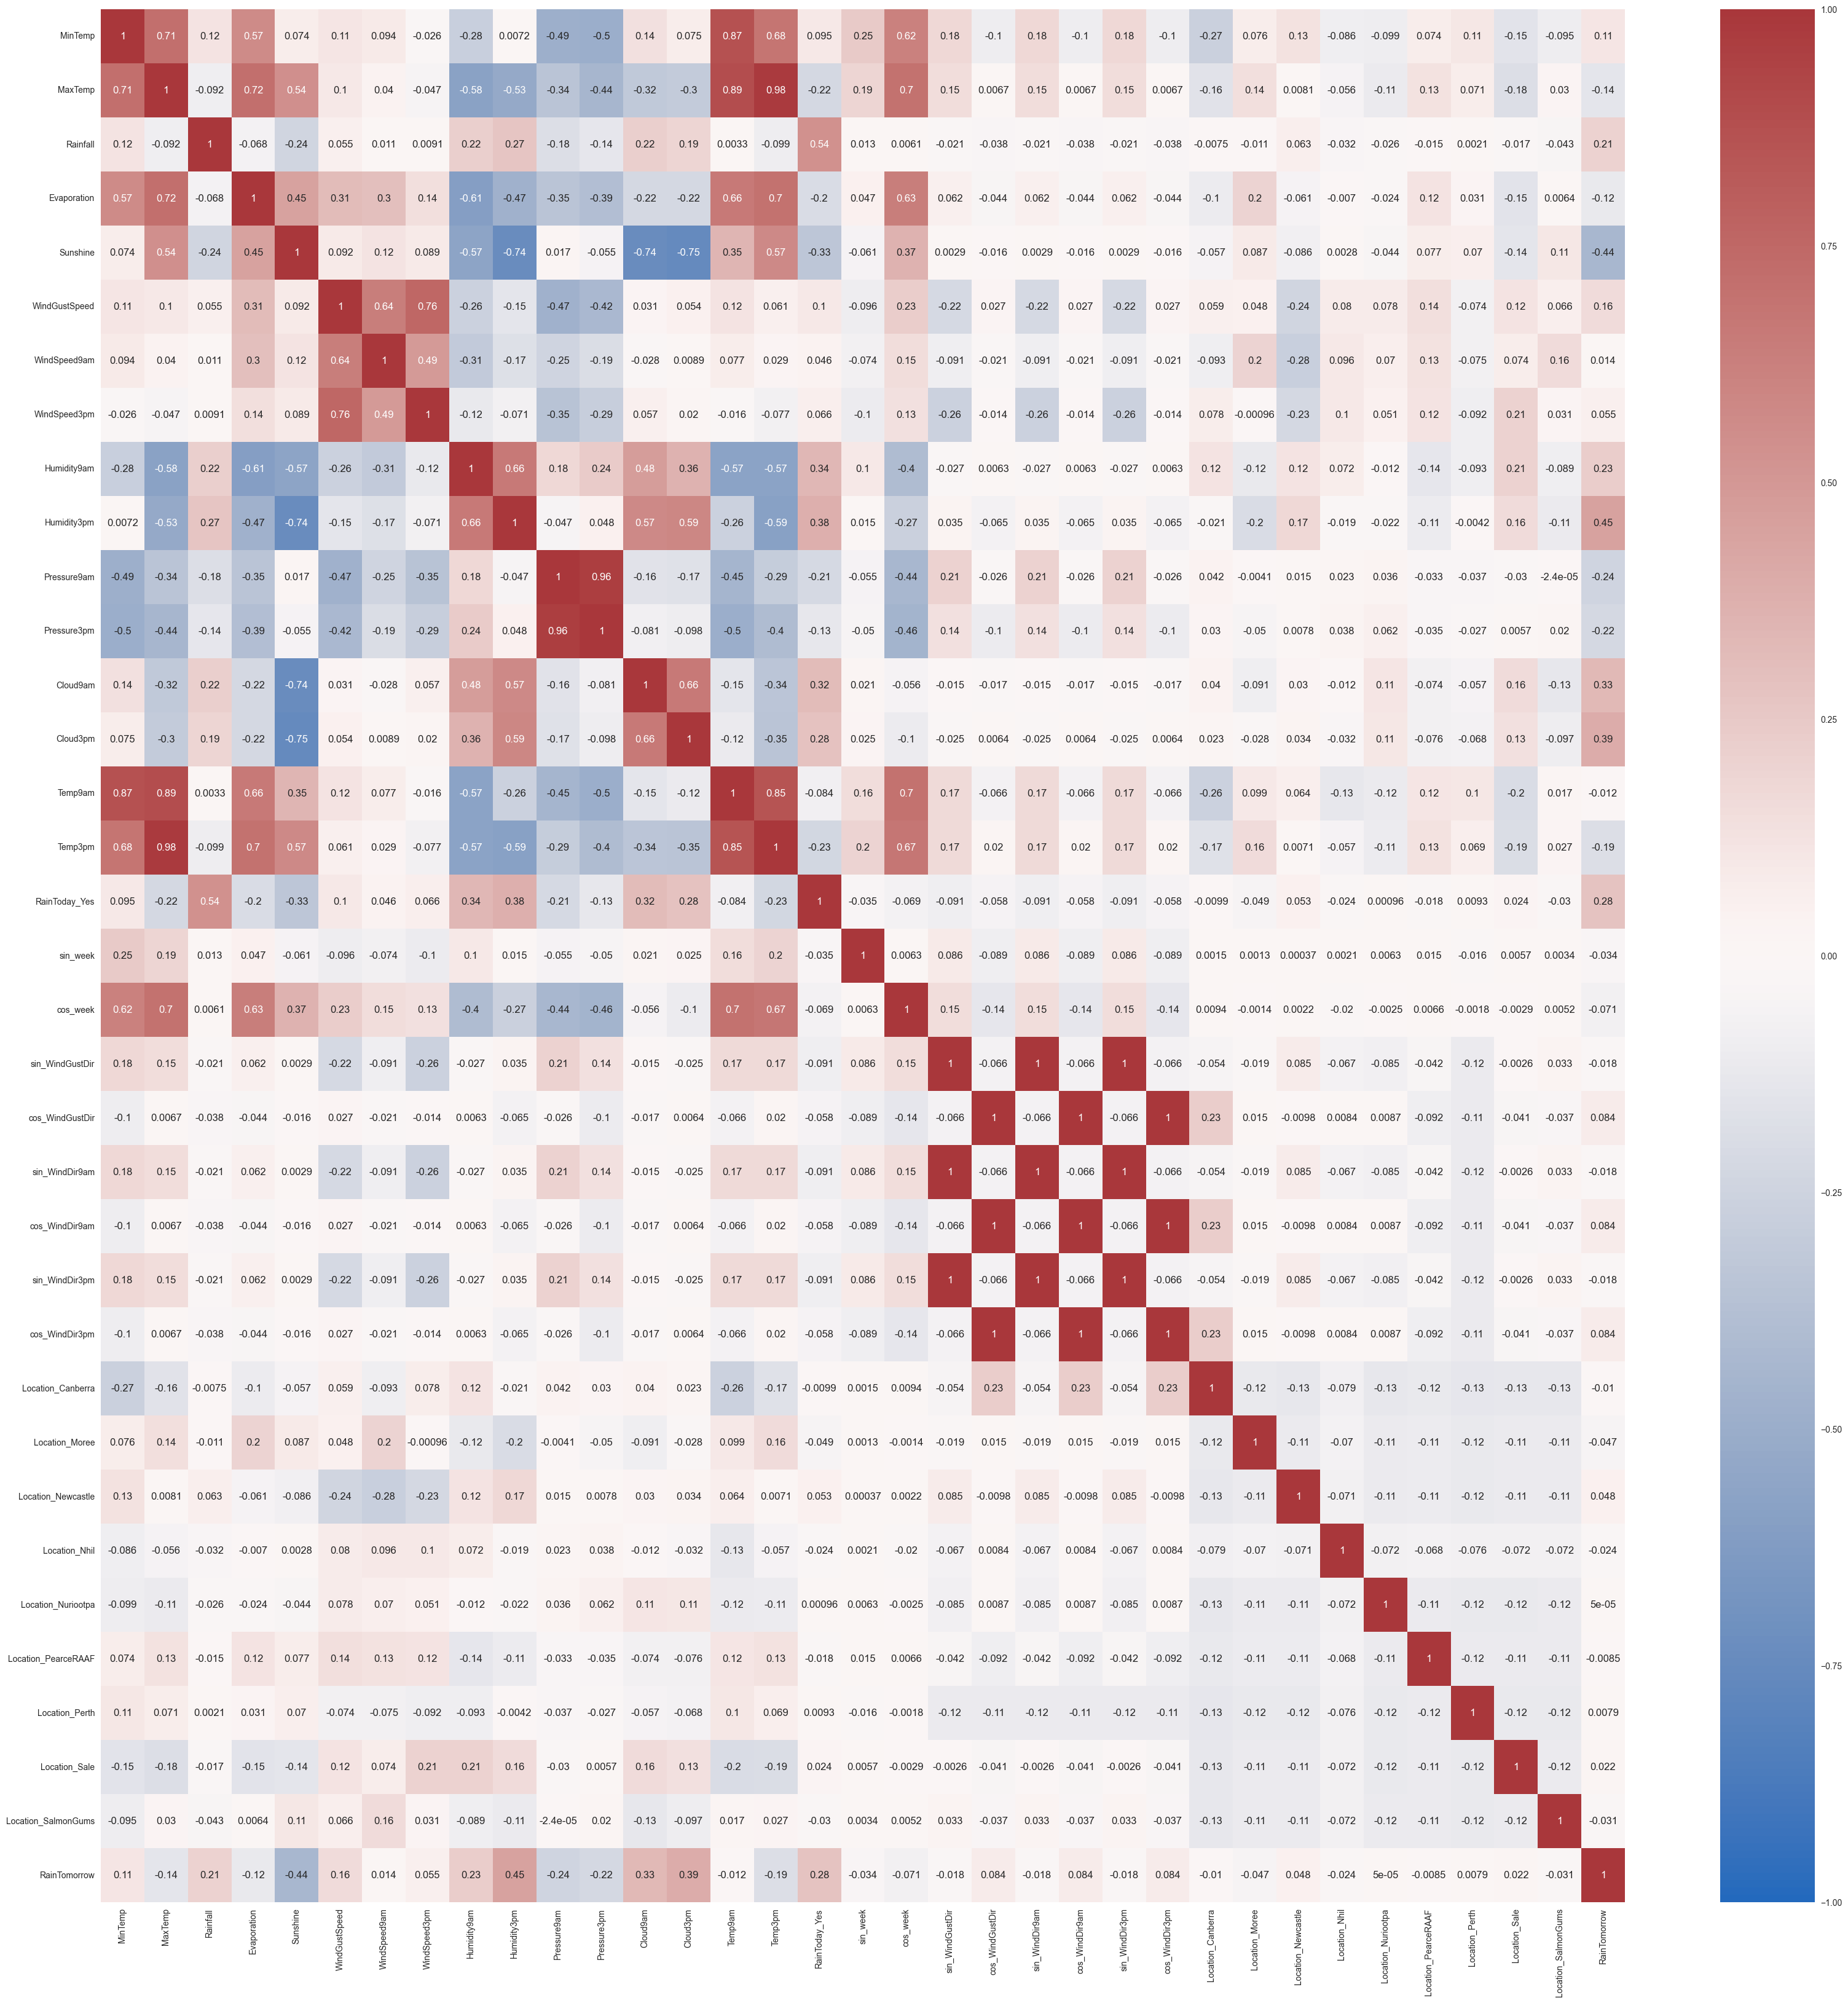

In [136]:
matriz_completa = df_train_completo.corr()

fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(matriz_completa, annot=True, vmax=1, vmin=-1, cmap='vlag')
plt.show()

En la matriz de correlación de variables de Pearson, podemos observar que hay fuertes relaciones entre:

* Se observa que hay una relación positiva muy alta entre Temp9pm y MaxTemp de (0.89), esta es una correlación que ya podíamos intuir, ya que estamos viendo la relación entre la temperatura en un horario de tarde y la temperatura máxima. También vemos que la relación con MinTemp es de (0.87) por lo mismo, pero en este caso podemos suponer que es menor por el horario donde son medidas estas temperaturas

* Se observa una relación mucho menor entre Temp3pm y MinTemp de (0.68), esto se puede entender por el horario donde son tomados los datos de temperatura, diferente es el caso de la relación con MaxTemp, que es de (0.98) notando que tiene una relación positiva perfecta, esto es correcto si suponemos que la mayor temperatura se da en el rango de a las 3 pm, que es cuando son tomadas estas medidas de temperatura. También se puede observar una relación positiva alta con Evaporation (0.7), esto también podemos notar que está relacionado con una alta correlación de la temperatura máxima (MaxTemp), ya que a mayor temperatura, se espera una mayor evaporación. Además, una relación esperable con Temp9am de (0.86), siendo esta positivamente alta

* Se puede apreciar una relación negativa alta entre Cloud3pm y Sunshine de (-0.75), esto quiere decir que, en el caso de que haya mayor cantidad de nubes, va a ver una menor cantidad de luz solar, esto mismo sucede con Cloud9pm y Sunshine, teniendo también una relación negativa alta de (-0.73)

* Se puede observar una relación positiva casi perfecta entre Pressure3pm y Pressure9am de (0.96), lo que quiere decir que las presiones en distintos horarios suelen ser altamente similares y estar muy relacionadas

* Se puede notar que existe una relación negativa alta entre Humidity3pm y Sunshine de (-0.73), lo que nos da a entender que si nuestra humedad es muy alta es porque tenemos una cantidad muy baja de radiación solar o "Sunshine"


### Clasificación con regresión logística

In [137]:
modelo_relog =LogisticRegression(class_weight='balanced',random_state=25923)
modelo_relog.fit(x_train_procesado_iterative, y_train_codif)
y_probs_relog = modelo_relog.predict_proba(x_test_procesado_iterative)[:, 1]

y_pred_relog = modelo_relog.predict(x_test_procesado_iterative)


modelo_relog_desba = LogisticRegression(random_state=25923)
modelo_relog_desba.fit(x_train_procesado_iterative, y_train_codif)
y_probs_relog_desba = modelo_relog_desba.predict_proba(x_test_procesado_iterative)[:, 1]

y_pred_relog_desba = modelo_relog_desba.predict(x_test_procesado_iterative)

In [116]:
x_train_procesado_iterative.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,cos_WindDir3pm,Location_Canberra,Location_Moree,Location_Newcastle,Location_Nhil,Location_Nuriootpa,Location_PearceRAAF,Location_Perth,Location_Sale,Location_SalmonGums
count,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,...,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000
mean,0.484707,0.452244,0.007801,0.085903,0.452502,0.251009,0.150940,0.203157,0.619908,0.463948,...,-0.018918,0.123137,0.099544,0.100717,0.042798,0.105149,0.094721,0.113317,0.105192,0.103150
std,0.156376,0.155792,0.028755,0.057128,0.197176,0.114779,0.102868,0.107186,0.175876,0.195585,...,0.666315,0.328602,0.299397,0.300960,0.202406,0.306752,0.292835,0.316987,0.306808,0.304161
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.372449,0.335648,0.000000,0.046053,0.314607,0.166667,0.072289,0.132530,0.500000,0.313131,...,-0.707100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.484694,0.439815,0.000000,0.077303,0.488764,0.236842,0.132530,0.180723,0.625000,0.464646,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.599490,0.562500,0.001667,0.118421,0.601124,0.307018,0.228916,0.265060,0.750000,0.585859,...,0.707100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Métricas

In [164]:
metricas_relog = calcular_metricas_modelo(y_test_codif, y_pred_relog, 'Relog balanceada')
metricas_relog_desba = calcular_metricas_modelo(y_test_codif, y_pred_relog_desba, 'Relog desbalanceada')
display(metricas_relog,metricas_relog_desba)

,Accuracy,Precision,Recall,F1,Matthews,Jaccard,Wrecall
Relog balanceada - Llueve,0.801005,0.486297,0.756806,0.592119,0.488685,0.420575,0.783166
Relog balanceada - No Llueve,0.801005,0.933974,0.811430,0.868400,0.488685,0.420575,0.783166


,Accuracy,Precision,Recall,F1,Matthews,Jaccard,Wrecall
Relog desbalanceada - Llueve,0.867336,0.743478,0.465517,0.572545,0.518066,0.401095,0.627446
Relog desbalanceada - No Llueve,0.867336,0.884146,0.962115,0.921484,0.518066,0.401095,0.627446


Se calculan las métricas de Accuaracy, Precicion, Recall, F1, Matthews, Jaccard y Wrecall para los modelos balanceados y desbalanceados del imputador iterativo.
En Accuaracy, medimos la proporción de predicciones correctas sobre el total de predichas, en el contexto de si llueve o no llueve, mostrando que en el modelo balanceado, la exactitud es menor que la del modelo desbalanceado, esto gracias a que el dataset está desbalanceado con respecto a los días lluviosos que a los que no. 

En Precisión, medimos de la proporción de verdaderos positivos sobre todos los ejemplos predichos como positivos, vemos que las predicciones del modelo balanceado están más cercanos en sus predicciones que el modelo desbalanceado que demuestra la baja cantidad de valores, teniendo una mucho mayor cantidad de datos para llueve que para no llueve

En Recall, dentro de la misma categoría, cuenta cuantos fueron correctamente clasificados. Las métricas demuestran que tenemos clases altamente desbalanceadas, al tener un reccal muy alto y uno muy bajo, por lo que no es muy acorde para este dataset

En F1, medimos la cantidad de falsos negativos y falsos positivos, dando valores medianamente acordes, ya que es buena para datasets desbalanceados, pudiendo ver en qué se respetan los valores bajos para cuando llueve y altos para cuando no llueve

Utilizamos Matthews, ya que considera todas las métricas de la matriz de confusión (TP, TN, FP, FN) y varía -1 y 1. En ambos modelos, Matthews valora las predicciones de forma global. En ambos modelos, las métricas son bastante bajas, indica cierta dificultad al momento de diferenciar de forma confiable en los días de lluvia de los que no.

El índice de Jaccard mide la intersección sobre la unión de las predicciones y las reales para la clase positiva, para ambos modelos. El índice de Jaccard es bajo para ambos, lo que sugiere que existe un nivel moderado de error en ambas predicciones, específicamente para los días que llueven

El Wrecall es una métrica que pondera los recall de ambas clases, que da más importancia a las clases en función de su frecuencia, mostrando que el Wrecall balanceado es superior al del desbalanceado, ya que para los días lluviosos el modelo demuestra valores muy dispares

#### Matriz de confusión

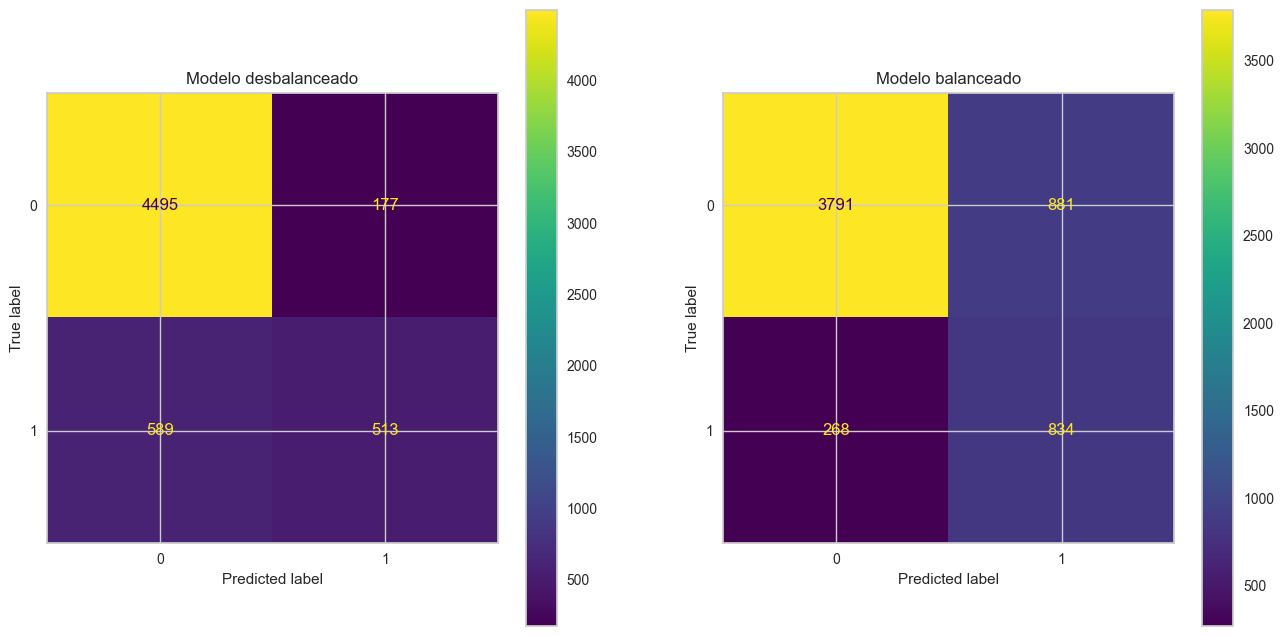

In [209]:
confusion_matrix_relog = confusion_matrix(y_test_codif, y_pred_relog)
confusion_matrix_relog_desba = confusion_matrix(y_test_codif, y_pred_relog_desba)

fig_matrix, axes_matrix = plt.subplots(1,2, figsize = (16, 8))

metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix_relog).plot(ax=axes_matrix[1])
axes_matrix[1].title.set_text('Modelo balanceado')

metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix_relog_desba).plot(ax=axes_matrix[0])
axes_matrix[0].title.set_text('Modelo desbalanceado')

plt.show()

Comentar los numeros de cada bloque

vemos que tenemos mas falsos negativos que falsos positivos, esto puede darse porque el dataset esta desbalanceado, teniendo pocos casos de lluvia.

Los falsos negativos quieren decir que el modelo predice que no iba a llover y llueve
Los falsos positivos quieren decir que el modelo pecide que va a llover y no llueve 

#### Curva ROC

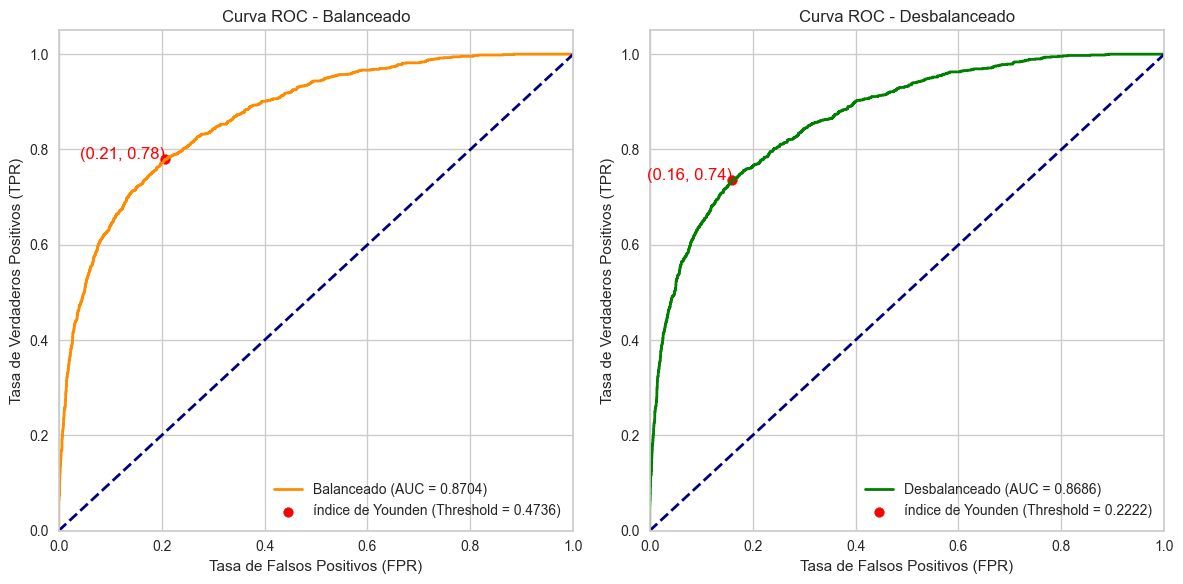

In [198]:
funciones_roc(y_test_codif, y_probs_relog, 'Balanceado', y_probs_relog_desba, 'Desbalanceado')

Vemos que los valores de ambas curvas ROC son similares gracias a que el área bajo la curva es símilar. Resultando en que la decisión para elegir uno de los dos modelos sea sobre la métrica seleccionada para la comparación de los modelos.

#### Modelo de regresión logística con datos interpolados

In [ ]:
modelo_relog_interpol =LogisticRegression(class_weight='balanced',random_state=25923)
modelo_relog_interpol.fit(x_train_procesado_interpol, y_train_codif)
y_probs_relog_interpol = modelo_relog.predict_proba(x_test_procesado_interpol)[:, 1]

y_pred_relog_interpol = modelo_relog.predict(x_test_procesado_interpol)


modelo_relog_desba_interpol = LogisticRegression(random_state=25923)
modelo_relog_desba_interpol.fit(x_train_procesado_interpol, y_train_codif)
y_probs_relog_desba_interpol = modelo_relog_desba.predict_proba(x_test_procesado_interpol)[:, 1]

y_pred_relog_desba_interpol = modelo_relog_desba.predict(x_test_procesado_interpol)

Se crea otro modelo logístico, pero en este caso utilizando el escalador de interpolación de variables, para así poder comprar y concretar qué modelo resulta dar valores más precisos

In [166]:
metricas_relog_interpol = calcular_metricas_modelo(y_test_codif, y_pred_relog_interpol, 'Relog interpol balanceada')
metricas_relog_interpol_desba = calcular_metricas_modelo(y_test_codif, y_pred_relog_desba_interpol, 'Relog interpol desbalanceada')
display(metricas_relog_interpol,metricas_relog_interpol_desba)

,Accuracy,Precision,Recall,F1,Matthews,Jaccard,Wrecall
Relog interpol balanceada - Llueve,0.82629,0.543459,0.561706,0.552432,0.444793,0.381628,0.688342
Relog interpol balanceada - No Llueve,0.82629,0.895793,0.888699,0.892232,0.444793,0.381628,0.688342


,Accuracy,Precision,Recall,F1,Matthews,Jaccard,Wrecall
Relog interpol desbalanceada - Llueve,0.846207,0.713147,0.324864,0.446384,0.410121,0.287319,0.486616
Relog interpol desbalanceada - No Llueve,0.846207,0.858877,0.969178,0.910700,0.410121,0.287319,0.486616


De manera general, se puede observar que para cada una de las diferentes métricas, la interpolación, resulta en peores valores, dándonos por resuelta la elección del IterativeImputer como nuestro imputador a utilizar

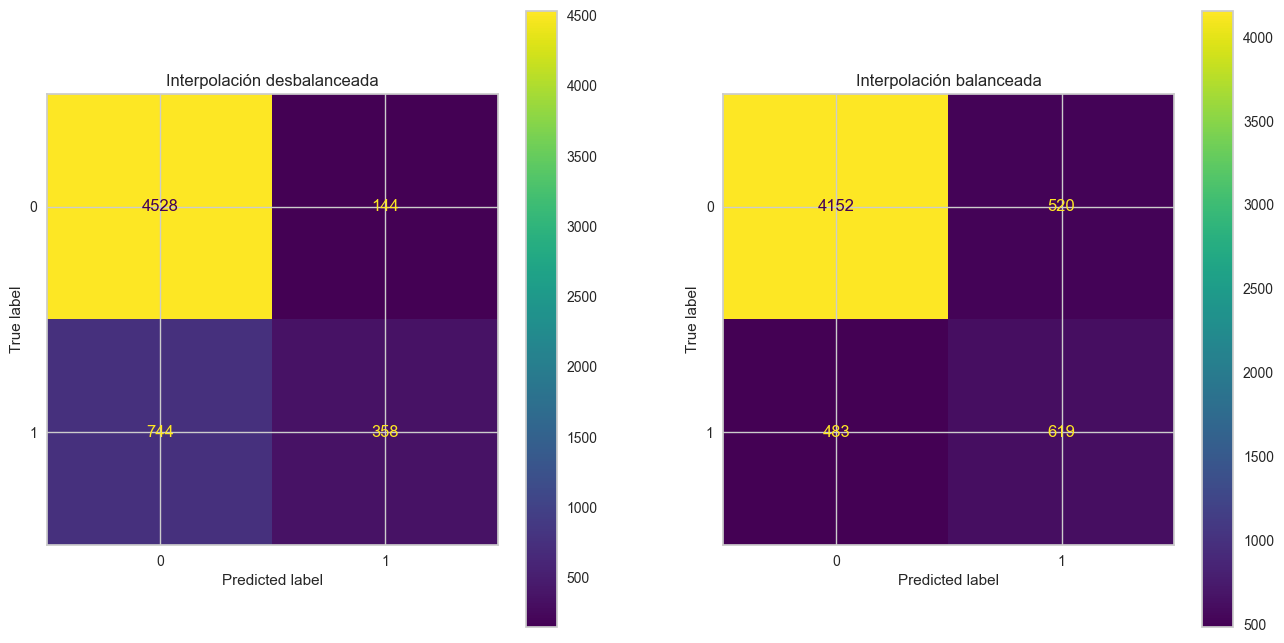

In [208]:
confusion_matrix_relog_interpol = confusion_matrix(y_test_codif, y_pred_relog_interpol)
confusion_matrix_relog_desba_interpol = confusion_matrix(y_test_codif, y_pred_relog_desba_interpol)


fig_matrix, axes_matrix = plt.subplots(1,2, figsize = (16, 8))

metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix_relog_interpol).plot(ax=axes_matrix[1])
axes_matrix[1].title.set_text('Interpolación balanceada')

metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix_relog_desba_interpol).plot(ax=axes_matrix[0])
axes_matrix[0].title.set_text('Interpolación desbalanceada')

plt.show()

También se puede observar que las matrices de confusión están peor distribuidas que las matrices de confusión del IterativeImputer

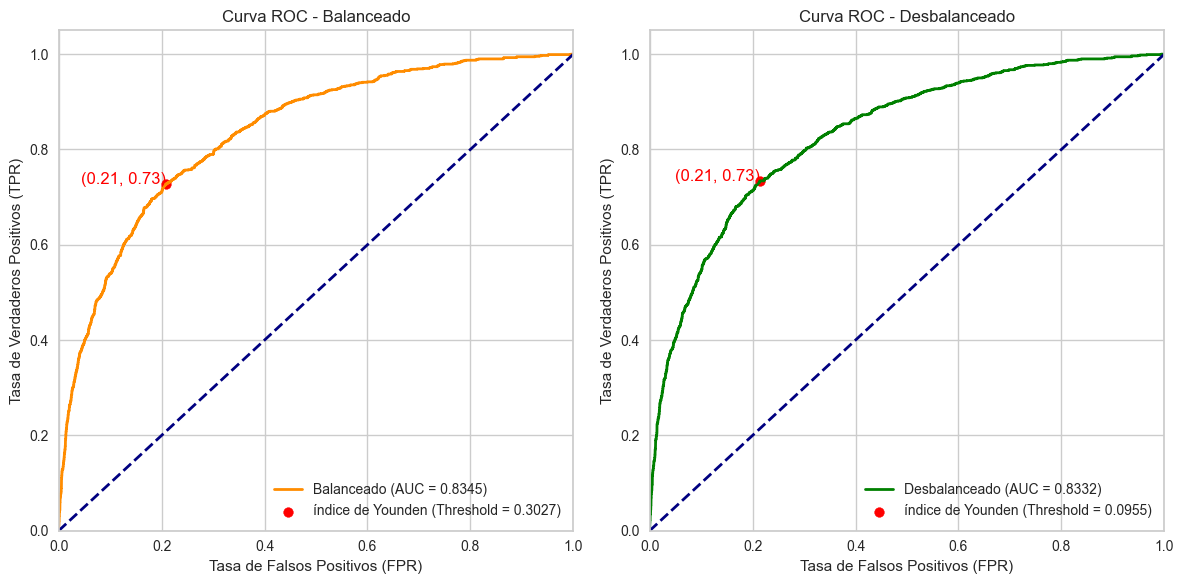

In [199]:
funciones_roc(y_test_codif, y_probs_relog_interpol, 'Balanceado', y_probs_relog_desba_interpol, 'Desbalanceado')

Observamos que los valores de AUC son similares, siendo inferiores a los del modelo con imputado iterativo.

### Modelo base


In [145]:
x_train_avg = x_train_procesado_iterative.mean(axis=1).astype(float)
x_test_avg = x_test_procesado_iterative.mean(axis=1).astype(float)

umbral = x_train_avg.mean()

y_pred_avg = (x_test_avg > umbral).astype(int)

y_pred_avg_prob = 1 / (1 + np.exp(-12 * (x_test_avg - umbral)))

Para nuestro modelo base se planteó generar un promedio de los valores en ambos conjuntos, de entrenamiento y testeo, para luego con estos valores únicos, utilizarlos como métricas para generar un umbral con los valores promedios totales del conjunto promedio de entrenamiento, donde se genera como resultado 0 o 1, si el valor de testeo, supera ese umbral, dando como resultado que no lloverá o, por lo contrario, que sí va a llover. Luego, se plantea una función sigmoide donde nuestro punto medio de la función sea el umbral, localizado aproximadamente en 0.36, estirando la función para que sea abrupta en ambos lados del umbral, para así poder calcular los promedios de cada valor promedio de testeo y poder ser así evaluado en una curva ROC

#### Métricas

In [167]:
metricas_base = calcular_metricas_modelo(y_test_codif, y_pred_avg, 'Modelo Base')
display(metricas_base)

,Accuracy,Precision,Recall,F1,Matthews,Jaccard,Wrecall
Modelo Base - Llueve,0.526498,0.217452,0.569873,0.314787,0.067702,0.186794,0.541747
Modelo Base - No Llueve,0.526498,0.835759,0.516267,0.638264,0.067702,0.186794,0.541747


Si comparamos los resultados de nuestro modelo base basado en promedios con las métricas de nuestro modelo logístico, podemos ver que, en el caso de Accuaracy, que devuelve valores peores, luego que en Precisión, se nota la gran falta de valores en el caso de no lluvia, lo mismo sucede en recall, mostrando un gran desbalance en los casos de lluvia y no lluvia, lo mismo para F1.
Matthews y Jaccard, siguiendo el mismo camino, dan resultados inferiores junto con el Wrecall. Aun con valores inferiores en cada métrica, es un modelo que se acerca mucho al modelo que utiliza interpolación como métrica de imputación, pudiendo ser tomado en cuanto como un modelo aceptable en cuanto a modelos bases sencillos se refiere, al únicamente tomar como métrica una función sigmoide alterada

#### Matriz de confusión

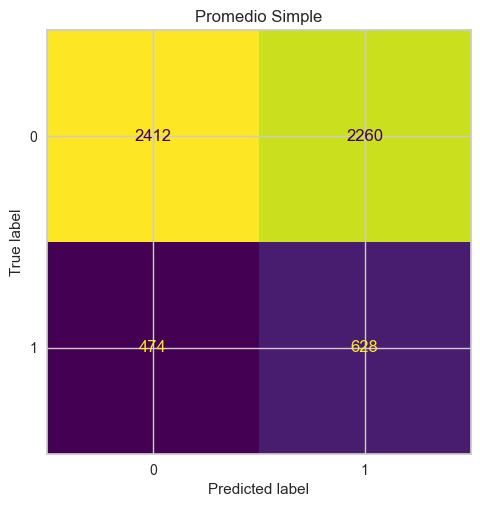

In [211]:
confusion_matrix_avg = confusion_matrix(y_test_codif, y_pred_avg)

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_avg).plot(colorbar=False)
plt.title('Promedio Simple')

plt.show()

Podemos observar que en este modelo, como fue visto en las métricas antes calculadas, los FP son similares a los TN y los FN son similares a los TP. La métrica que me permite deducir esto es el Wrecall.

#### Curva ROC

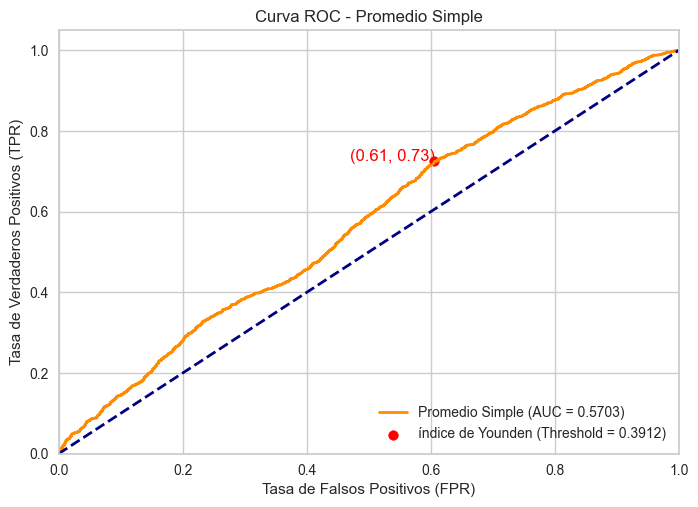

In [200]:
funciones_roc(y_test_codif, y_pred_avg_prob, 'Promedio Simple')

Obtenemos una métrica ROC con valores ligeramente mejores que la predicción random

### Optimizar la selección de hiperparámetros.

#### Validación cruzada

In [201]:
my_scorer = make_scorer(calcular_wrecall_estimador, greater_is_better=True)

modelo_relog_val =LogisticRegression(class_weight='balanced',random_state=25923)
modelo_relog_desba_val =LogisticRegression(random_state=25923)
modelo_relog_interpol =LogisticRegression(class_weight='balanced',random_state=25923)
modelo_relog_interpol_desba =LogisticRegression(random_state=25923)

time_split = TimeSeriesSplit(n_splits=5)

val_relog_balanced_iterative = cross_val_score(modelo_relog_val, x_train_procesado_iterative, y_train_codif, scoring=my_scorer, cv=time_split.split(x_train_procesado_iterative))
val_relog_desba_iterative = cross_val_score(modelo_relog_desba_val, x_train_procesado_iterative, y_train_codif, scoring=my_scorer, cv=time_split.split(x_train_procesado_iterative))

val_relog_balanced_interpol = cross_val_score(modelo_relog_interpol, x_train_procesado_interpol, y_train_codif, scoring=my_scorer, cv=time_split.split(x_train_procesado_iterative))
val_relog_desba_interpol = cross_val_score(modelo_relog_interpol_desba, x_train_procesado_interpol, y_train_codif, scoring=my_scorer, cv=time_split.split(x_train_procesado_iterative))


validations = pd.DataFrame(data=[val_relog_balanced_iterative,val_relog_desba_iterative,val_relog_balanced_interpol,val_relog_desba_interpol], index=['Iterative relog - balanceado', 'Iterative relog - desbalanceado', 'Interpolado relog - balanceado', 'Interpolado relog - desbalanceado'])

validations['promedios'] = [np.mean(val_relog_balanced_iterative),np.mean(val_relog_desba_iterative),np.mean(val_relog_balanced_interpol),np.mean(val_relog_desba_interpol)]
display(validations)

,0,1,2,3,4,promedios
Iterative relog - balanceado,0.800658,0.797501,0.790328,0.804979,0.792896,0.797272
Iterative relog - desbalanceado,0.642993,0.647700,0.655417,0.653214,0.621966,0.644258
Interpolado relog - balanceado,0.794301,0.789789,0.778447,0.784794,0.766929,0.782852
Interpolado relog - desbalanceado,0.633063,0.646630,0.626165,0.588595,0.556656,0.610222


Observamos que utilizando kfolds (timeseriessplit, ya que es un serie de tiempo) se pueden optimizar hiperparametros de una manera sencilla, el unico problema es que esta optimización es muy manual, siendo que tendría que ir cambiando los hiperparametros en cada ejecución

#### Optuna

In [214]:
def optuna_parametros(trial):
    penalty = trial.suggest_categorical('penalty', ['l2','l1',None])
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    tol = trial.suggest_float('tol', 0.000001, 100)
    C = trial.suggest_loguniform('C', 0.000001, 100)

    if (penalty == 'none' and solver != 'lbfgs') or \
        (penalty == 'l1' and solver not in ['liblinear', 'saga']) or \
        (penalty == 'elasticnet' and solver != 'saga'):
        return float('-inf')


    params = { 'penalty': penalty,'solver': solver, 'C': C, 'tol': tol, 'class_weight': 'balanced', 'random_state': 25923}

    model = LogisticRegression(**{k: v for k, v in params.items() if v is not None})
    model.fit(x_train_procesado_iterative, y_train_codif)
    
    y_pred = model.predict(x_test_procesado_iterative)
    scores = calcular_wrecall_estimador(y_test_codif, y_pred)

    return scores

study = optuna.create_study(direction='maximize')
study.optimize(optuna_parametros, n_trials=600)

best_optuna_params = study.best_params
best_optuna_model = LogisticRegression(**best_optuna_params, class_weight='balanced', random_state=25923)
best_optuna_model.fit(x_train_procesado_iterative, y_train_codif)

y_pred_opt_optuna = best_optuna_model.predict(x_test_procesado_iterative)
optuna_metrics = calcular_wrecall_estimador(y_test_codif, y_pred_opt_optuna)
y_pred_opt_optuna_prob = best_optuna_model.predict_proba(x_test_procesado_iterative)[:,1]

[I 2024-11-14 17:40:39,711] A new study created in memory with name: no-name-487ba75c-4e52-4ade-9553-5d7037e5209a
[I 2024-11-14 17:40:39,774] Trial 0 finished with value: 0.7775614015980751 and parameters: {'penalty': 'l2', 'solver': 'saga', 'tol': 9.083579185441865, 'C': 10.564433429969325}. Best is trial 0 with value: 0.7775614015980751.
[I 2024-11-14 17:40:39,854] Trial 1 finished with value: 0.0 and parameters: {'penalty': None, 'solver': 'liblinear', 'tol': 74.99066895092959, 'C': 2.333745481367761}. Best is trial 0 with value: 0.7775614015980751.
[I 2024-11-14 17:40:39,907] Trial 2 finished with value: 0.0 and parameters: {'penalty': None, 'solver': 'lbfgs', 'tol': 68.13629584773517, 'C': 51.56127174402042}. Best is trial 0 with value: 0.7775614015980751.
[I 2024-11-14 17:40:39,913] Trial 3 finished with value: -inf and parameters: {'penalty': 'l1', 'solver': 'newton-cg', 'tol': 74.68365526973504, 'C': 0.006884784253105503}. Best is trial 0 with value: 0.7775614015980751.
[I 2024

In [215]:
print(optuna_metrics, best_optuna_params)

0.7882551818634655 {'penalty': 'l2', 'solver': 'saga', 'tol': 0.06676959455977947, 'C': 4.55756246112119}


Decidimos utilizar Optuna, ya que al tener varios hiperparametros para ajustar gridsearch era demasiado lento y es sobre valores discretos que dificulta la selección de los mismos, aún asi tiene la posibilidad de usar rangos, pero esto puede terminar en una búsqueda demasiado extensa y que tardaría mucho en terminar. Por otro lado RandomSearch no tiene el mismo problema que gridsearch ya que podemos limitar los valores que busca en la grilla, pero al ser random terminamos haciendo muchas tiradas para llegar a un punto óptimo, lo que no me parece tan cómodo o confiable. 

Optuna tiene la caracteristica de buscar de manera eficaz sobre los rangos de valores que se le ingresan para entrenar al modelo, ahorrando tiempo y acercandose a valores bastante óptimos sin tardar demasiado.

##### Métricas 

In [216]:
calcular_metricas_modelo(y_test_codif, y_pred_opt_optuna, 'Modelo Optimizado con Optuna')

,Accuracy,Precision,Recall,F1,Matthews,Jaccard,Wrecall
Modelo Optimizado con Optuna - Llueve,0.795636,0.478212,0.776770,0.591978,0.490143,0.420432,0.788255
Modelo Optimizado con Optuna - No Llueve,0.795636,0.938253,0.800086,0.863678,0.490143,0.420432,0.788255


##### Matriz de confusión

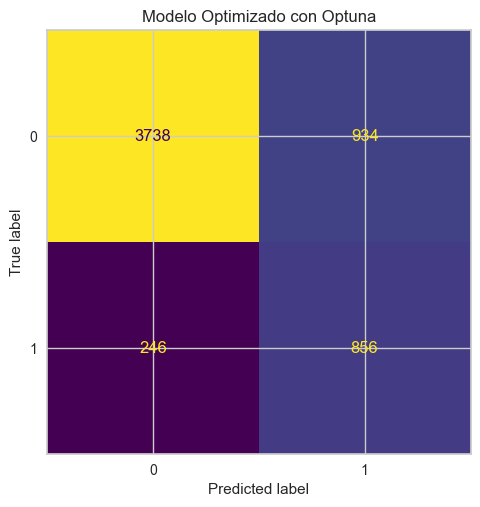

In [217]:
confusion_matrix_opt_optuna = confusion_matrix(y_test_codif, y_pred_opt_optuna)

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_opt_optuna).plot(colorbar=False)
plt.title('Modelo Optimizado con Optuna')
plt.show()

Se observa que no hay mucha diferencia con la matriz de confusión del modelo sin optimización, lo que si parece haber un pequeño trade-off entre TP-FN y TN-FP, es decir, obtengo mejores predicciones sobre los días de lluvia a cambio de predecir un poco peor los días que no llueve. 

##### Curva ROC

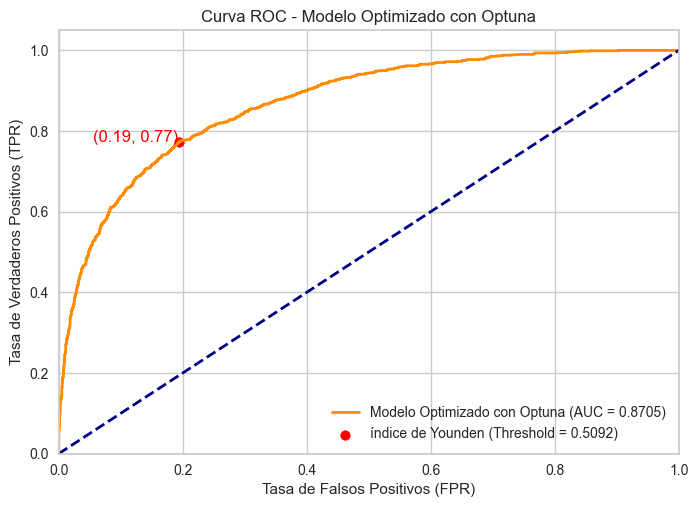

In [218]:
funciones_roc(y_test_codif, y_pred_opt_optuna_prob, 'Modelo Optimizado con Optuna')


### Explicabilidad de los modelos

#### Interpretación local con SHAP

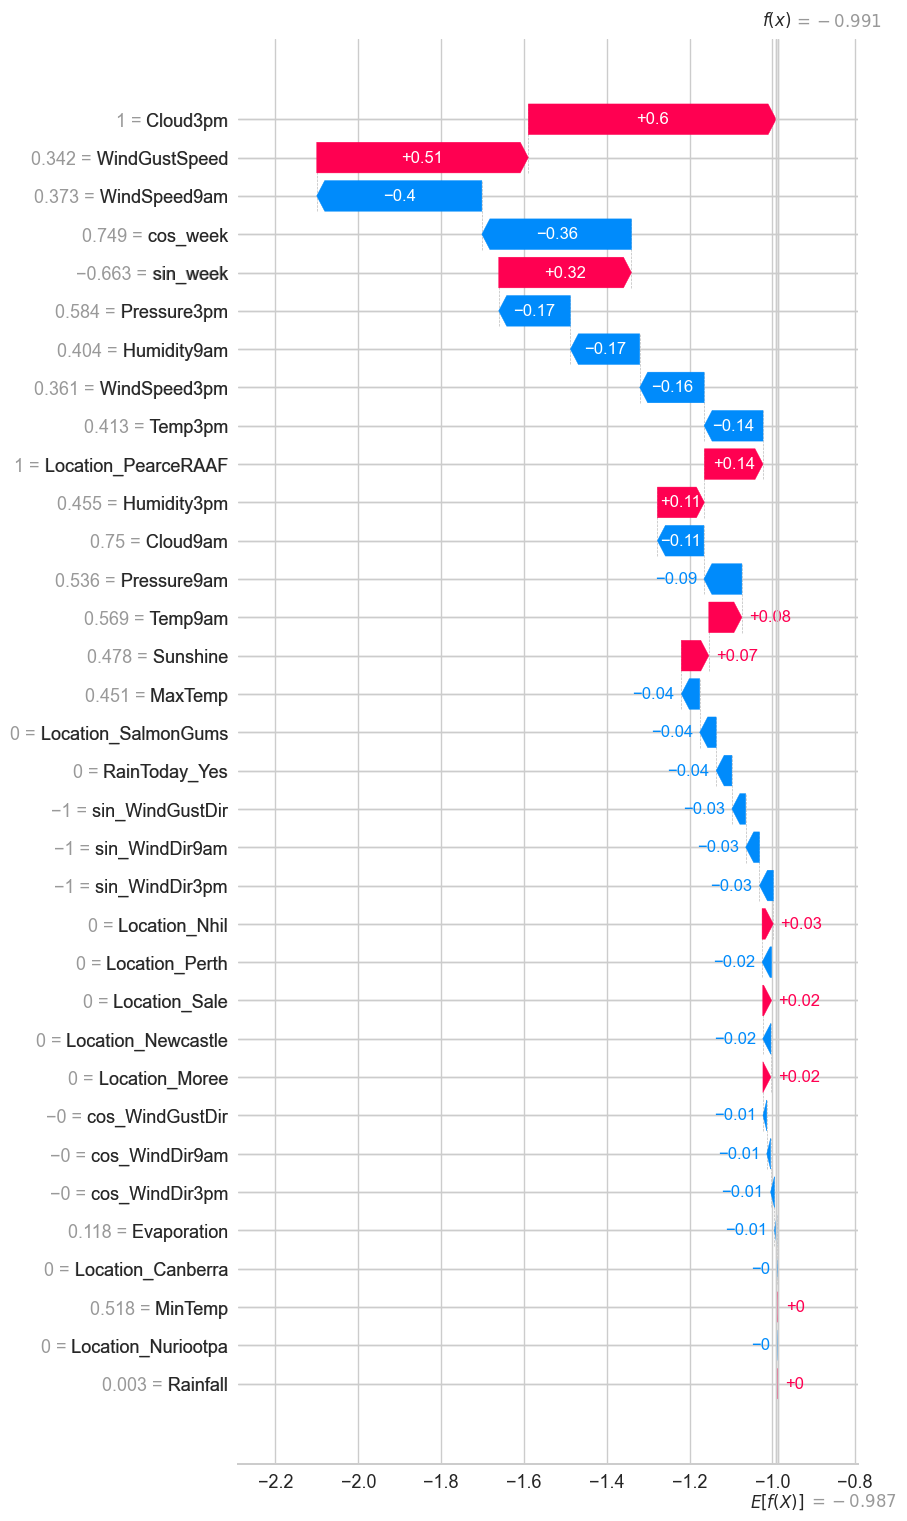

In [175]:
explainer = shap.Explainer(modelo_relog, x_test_procesado_iterative, feature_names=x_train_procesado_iterative.columns)
shap_values = explainer(x_test_procesado_iterative)
shap.plots.waterfall(shap_values[0], max_display=35)

Interpretando las variables localmente en el primer dato, se observa que las variables más importantes son Cloud3pm, Temp9am, week(siendo el seno y coseno), Localidad (siendo las 9 variables de onehotencoding), Temp3pm y RainToday_Yes. Por otro lado las menos importantes son Evaporation, MaxTemp, Humidity3pm, Rainfall y Humidity9am.

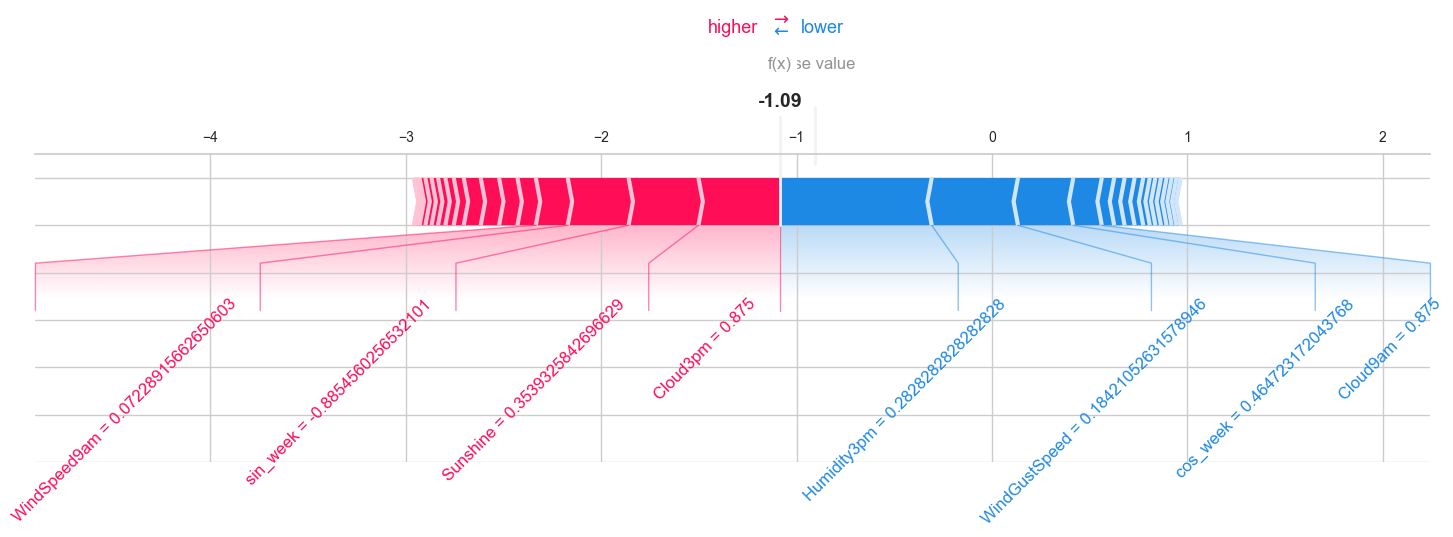

In [174]:
shap_values_exp = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=x_test_procesado_iterative.iloc[0].values, feature_names=x_test_procesado_iterative.columns)
shap.force_plot(shap_values_exp, matplotlib=True, figsize=(18, 4), text_rotation=45)

#### Interpretación global con SHAP

In [157]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=x_train_procesado_iterative.columns, data=x_test_procesado_iterative)

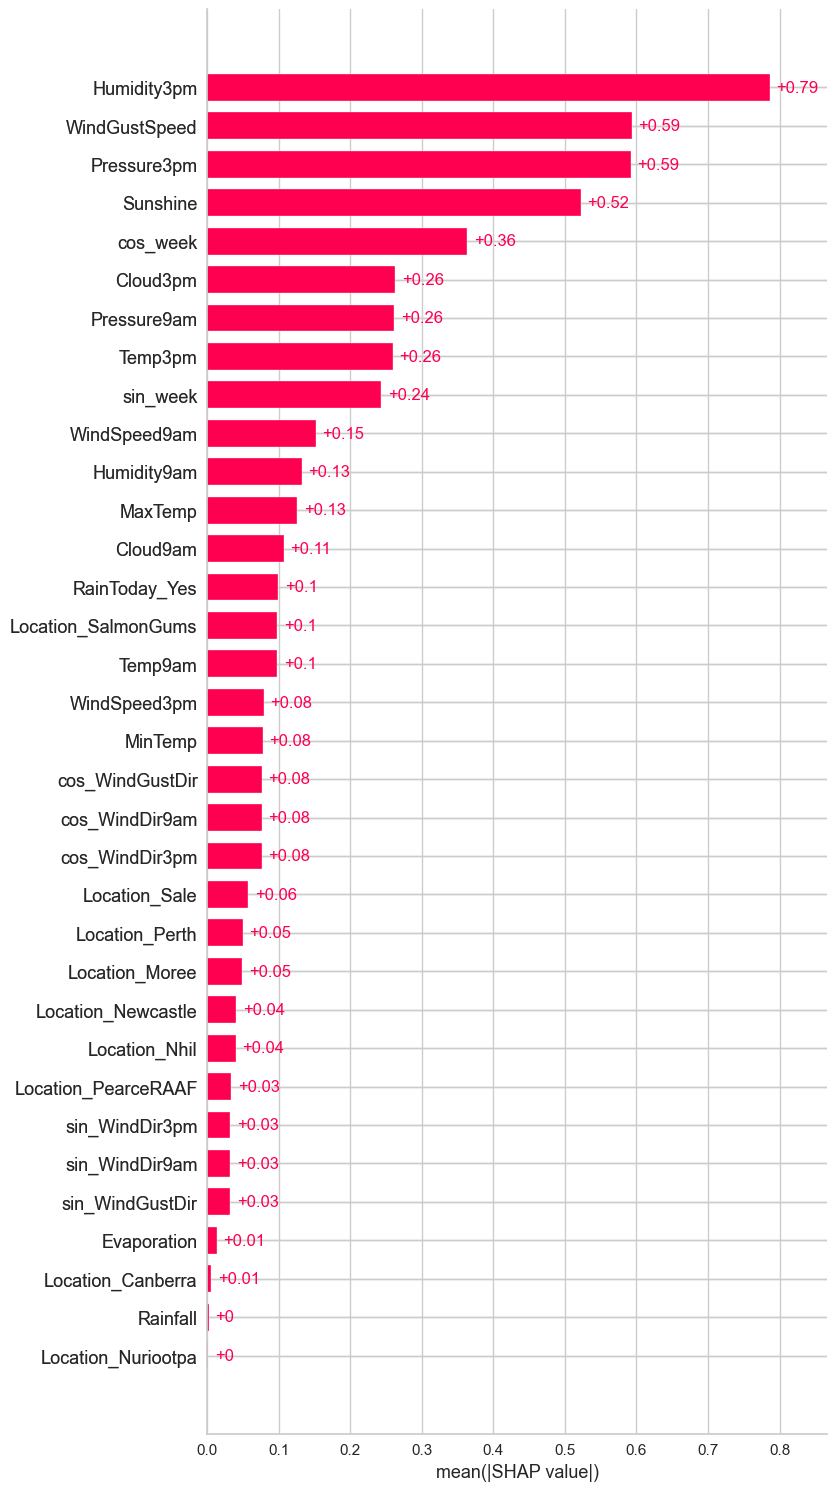

In [158]:
shap.plots.bar(explanation, max_display=35)

Interpretando las variables globalmente, se observa que las más importantes son Humidity3pm, WindGustSpeed, Pressure3pm, Sunshine, Cloud3pm, Temp3pm , week (siendo sin_week y cos_week en conjunto) y Pressure9am. Por otro lado, las menos importantes son MinTemp, WindSpeed3pm,  Rainfall, Temp9am, Evaporation.

In [159]:
x_train_procesado_iterative = x_train_procesado_iterative.astype({col: 'int32' for col in x_train_procesado_iterative.select_dtypes('bool').columns})

In [160]:
explainer = shap.Explainer(modelo_relog, x_train_procesado_iterative)
shap_values = explainer(x_train_procesado_iterative)

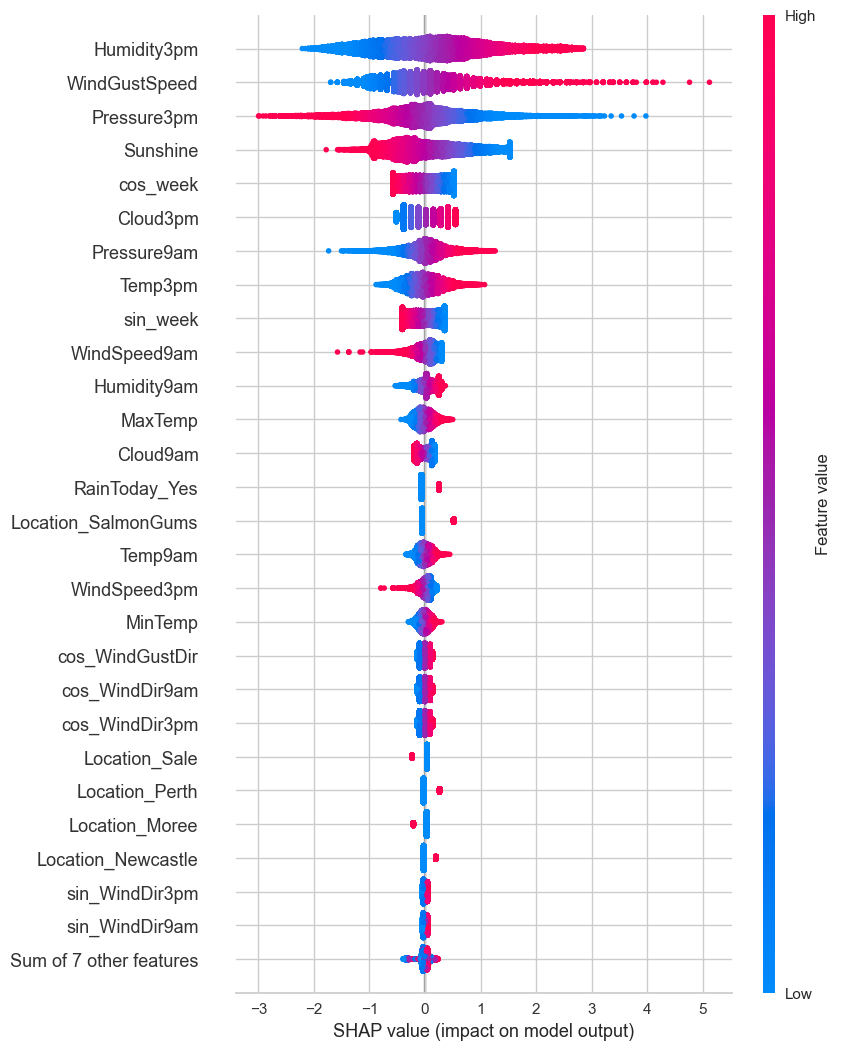

In [161]:
shap.plots.beeswarm(shap_values, max_display=28)

Tenemos una hipótesis de que ciertas variables las cuales fueron codificadas, no son facilmente interpretables por SHAP, ya que la variable en sí es el conjunto de todas sus variables codificadas, por ejemplo si tuviera la localidad la cual por onehotencoding no tiene una variable de 0 y 1, sino es el descarte de que no es el clima de todas las otras localidades, el SHAP no lo podría interpretar como una sola variable, sino el conjunto de todas las variables en 0, lo mismo con los senos y cosenos de diferentes variables.

También concluimos que la interpretación global tiene el problema de que no aplica para todos los datos, siendo que si interpretaramos dato por dato, cada uno tiene una interpretación shap diferente.

### AutoML

In [66]:
df_ciudad_ord['Date'] = pd.to_datetime(df_ciudad_ord['Date'])

In [67]:
# exp_name = setup(data = df_ciudad_ord,  target = 'RainTomorrow', 
#                 numeric_features=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 
#                                     'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
#                                     'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am','Temp3pm',],
#                 categorical_features=['RainToday','Location','WindGustDir','WindDir9am', 'WindDir3pm'],
#                 date_features=['Date'],
#                 imputation_type='iterative',
#                 normalize=True,
#                 normalize_method='minmax',
#                 fold_strategy='timeseries',
#                 data_split_shuffle=False,
#                 data_split_stratify=False,
#                 )
# add_metric('wrecall', 'Wrecall', calcular_wrecall_estimador, greater_is_better=True)
# lr = create_model('lr')

Se observa que aún agregando varios parámetros para un mejor AutoML, llega a las métricas superiores a las de nuestro modelo base implementado. 

In [72]:
exp_name = setup(data = df_ciudad_ord,  target = 'RainTomorrow')
lr_sencillo = create_model('lr')


,Description,Value
0,Session id,1357
1,Target,RainTomorrow
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(28869, 23)"
5,Transformed data shape,"(28869, 79)"
6,Transformed train set shape,"(20208, 79)"
7,Transformed test set shape,"(8661, 79)"
8,Numeric features,16
9,Date features,1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8580,0.8637,0.8580,0.8458,0.8435,0.4615,0.4823
1,0.8704,0.8810,0.8704,0.8611,0.8598,0.5222,0.5375
2,0.8624,0.8816,0.8624,0.8514,0.8506,0.4895,0.5056
3,0.8743,0.8695,0.8743,0.8664,0.8625,0.5283,0.5488
4,0.8674,0.8807,0.8674,0.8576,0.8575,0.5156,0.5286
5,0.8674,0.8808,0.8674,0.8576,0.8567,0.5124,0.5274
6,0.8699,0.8849,0.8699,0.8608,0.8610,0.5304,0.5416
7,0.8595,0.8674,0.8595,0.8483,0.8492,0.4890,0.5008
8,0.8688,0.8834,0.8688,0.8593,0.8583,0.5172,0.5321


Se observa que en el caso de hacer un AutoML por default, las métricas del modelo son muy parecidas que las de el modelo base.